In [69]:
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Conv1D, LSTM, Embedding, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2,l1
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
##### READ DATA FILES #####
x_train = pd.read_csv('./train.csv')
print(' '.join(train.columns.values))
###########################

id target comment_text severe_toxicity obscene identity_attack insult threat asian atheist bisexual black buddhist christian female heterosexual hindu homosexual_gay_or_lesbian intellectual_or_learning_disability jewish latino male muslim other_disability other_gender other_race_or_ethnicity other_religion other_sexual_orientation physical_disability psychiatric_or_mental_illness transgender white created_date publication_id parent_id article_id rating funny wow sad likes disagree sexual_explicit identity_annotator_count toxicity_annotator_count


In [32]:
x_train['word_count'] = x_train.comment_text.apply(lambda x: len(str(x).split(' ')))
x_train['is_toxic'] = x_train.target >= 0.5

1804874
mean word count 51.86124017521445
median word count 35.0


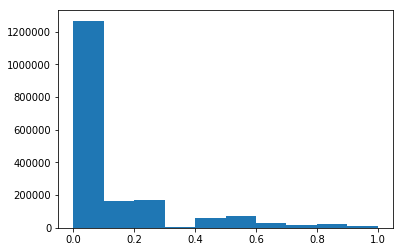

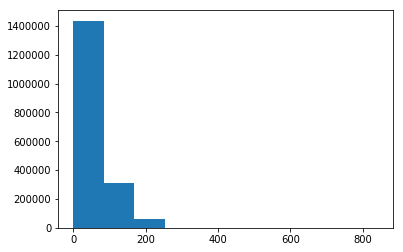

In [34]:
##### SEE DATA FILES #####
print(len(x_train))
plt.hist(x_train.target)
plt.figure()
plt.hist(x_train.word_count)
print('mean word count', np.mean(x_train.word_count))
print('median word count', np.median(x_train.word_count))
#for name, group in x_train.groupby('rating'):
#    print(name, np.mean(group.target))
#for col in x_train.columns:
#    print(col, np.sum(x_train[col] == 0.0) / len(x_train))
###########################

In [28]:
#https://medium.com/@nehabhangale/toxic-comment-classification-models-comparison-and-selection-6c02add9d39f
# Tokenize and Pad
# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)
# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train.comment_text))
tokenized_train = tokenizer.texts_to_sequences(x_train.comment_text)
#tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

In [31]:
embedding_dim = 300
# Get embeddings
embeddings_index = {}
f = open('./glove.840B.300d.txt', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

vocab_size = len(embedding_matrix)
print('vocab', vocab_size)

(397709, 300)

In [85]:
max_len = 200
num_classes = 1
inputs = Input((max_len,))
# Add Embedding layer
embed = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)
# Add Convolutional layer
x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(embed)
x = MaxPooling1D(3)(x)
x = GlobalMaxPooling1D()(x)
x = BatchNormalization()(x)
# Add fully connected layers
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(num_classes, activation='sigmoid')(x)
# Initiate model
model = Model(inputs=inputs, outputs=x)

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 300)          119312700 
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 200, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                6450      
__________

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")

In [87]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_train, x_train.target,
                                                    test_size=0.2, random_state=1, shuffle=True, stratify=x_train.is_toxic)

processed_X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [ ]:
model.fit(processed_X_train, y_train, batch_size=124, epochs=1, verbose=1, callbacks=None, 
          validation_data=(processed_X_test, y_test), shuffle=True, initial_epoch=0)

Train on 1443899 samples, validate on 360975 samples
Epoch 1/1
 697872/1443899 [=============>................] - ETA: 1:13:30 - loss: 0.2529 - acc: 0.6995

In [ ]:
#http://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper.pdf
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        pos = - alpha * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        pos = y_true * pos
        neg = - alpha * K.pow(y_pred, gamma) * K.log(1.0 - y_pred)
        neg = (1.0 - y_true) * neg
        return pos + neg
    return loss

#initialize the bias
pi = 0.01
bias = -np.log((1-pi)/pi)
w0 = model.layers[-1].get_weights()
model.layers[-1].set_weights([w0[0], bias])